# Randomization analysis

In this notebook we investigate whether interactions with an unbalance of simple and twisted read pairs occur more often than expected by chance. Similar to the FDR procedure, we randomize the simple and twisted read pair counts in each interaction according to a binomial distribution with $p=0.5$ and then determine the total number of significant interactions at a given nominal alpha. But instead of doing only one iteration of this procedure, as we do for estimating the FDR, we do many interations, e.g. ``10,000``. If we never observe more significant interactions than for the non-randomized data, we speak of an empirical P-value of ``1/10000``. In addition, we calculate the mean and standard devaition for the numbers of randomized significant interactions from all iterations, and from this, in turn, a Z-score.

## Setting up the notebook

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes and functions:
* ``DiachromaticInteractionSet``
    - ``parse_file``: Read interactions from file
    - ``get_read_file_info_report``: Get information about files that have already been read in form of a formatted string
* ``RandomizeInteractionSet``
    - ``perform_randomization_analysis``: The entire randomzation analysis is carried out in this function using sub-functions that are also used for the FDR procedure, which is also implemented in ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read interactions from a file. The FDR procedure is carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

We use the test file with ``64,000`` interactions, which we also use to test the FDR procedure.

In [2]:
ls ../tests/data/test_03/*top_64000*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz


## Demonstration of the analysis using the test file with ``64,000`` interactions

First, we read the interaction file into an interaction set.

In [2]:
interaction_set_demo = DiachromaticInteractionSet()
interaction_set_demo.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz', verbose=True)
read_file_info_report_demo = interaction_set_demo.get_read_file_info_report()
print(read_file_info_report_demo)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.



Next, we create an object of class ``RandomizeInteractionSet`` and pass the interaction set to this object.

In [3]:
randomization_analysis_demo = RandomizeInteractionSet(interaction_set=interaction_set_demo)

### Randomization parameters

Then we call the function ``perform_randomization_analysis`` of the class ``RandomizeInteractionSet`` in which the entire randomization analysis is implemented. To this function, a ``nominal_alpha`` is passed, which is used as the P-value threshold. Interactions that have a smaller P-value are counted as significant. In addition, the number of iterations can be specified (``iter_num`` defaults to ``1,000``).

### Paralell processing

Dependinng on the innput parameters, the analysis can be computational intensive. Therefore, batches of iterations can be performed out in paralell processes. If ``thread_num = 0`` (default), the Python package ``multiprocessing`` is not used and all iterations are performed in sequence. If ``thread_num = 1``, then the ``multiprocessing`` package is used, but all iterations are performed in a single process. If ``1 < thread_num``, the iterations are divided into batches that are performed in paralell processes. We use a different random seed for each iteration. Overall, however, we use the same seeds so that the same result is obtained, regardless of whether the iterations are performed in one or more processes. We implemented this in this way in order to be able to test the paralellization in a unit test.

In [4]:
randomization_analysis_demo_info_dict = randomization_analysis_demo.perform_randomization_analysis(
    nominal_alpha = 0.0025,
    iter_num = 1000,
    thread_num = 2,
    verbose = True)

[INFO] Performing randomization analysis with 1000 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 500 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 500 iterations ...
			[INFO] First iteration indices: 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  Fi

If we call the function with ``verbose = True``, progress messages are output. In this case, we have set ``thread_num = 2`` so that ``500`` iterations are performed in two parallel proccesses. Each iteration has its own index that we use as random seed.

### Results

The function ``perform_randomization_analysis`` returns a dictionary that contains all information about the analysis performed. The main results can be presented in a pandas ``DataFrame`` as follows:

In [5]:
pandas.DataFrame(randomization_analysis_demo_info_dict['RESULTS']['SUMMARY'])

,SIG_NUM_O,I_NUM_RANDOMIZED,SIG_NUM_R_GT_OBS,SIG_NUM_R_MEAN,SIG_NUM_R_STD,Z_SCORE
0,1424,38749,0,51.34,7.294272,188.183283


Alternatively, all information about the analysis caan be presennted in a formatted string as follows:

In [6]:
print(randomization_analysis_demo.get_randomization_info_report())

[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 64,000
		[INFO] Nominal alpha: 0.00250
		[INFO] Number of iterations: 1,000
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,424
		[INFO] Number of randomized interactions: 38,749
		[INFO] First 10 significant randomized interaction numbers: 
			52, 50, 45, 60, 43, 43, 46, 48, 47, 60, ...
		[INFO] Iterations with more significant interactions than observed: 0
		[INFO] Mean number of significant randomized interactions: 51.34
		[INFO] Standard deviation of significant randomized interactions: 7.29
		[INFO] Z-score: 188.18
[INFO] End of report.



The first section of the report shows the input parameters. For this analysis, we used an input file with ``64,000`` interactions. Interactions with a P-value smaller than the chosen nominal alpha (``0.00250``) were classified as significant and ``1,000`` iterations were performed. The second section of the report contains the results. At the chosen nominal alpha, ``1,424`` non-randomized input interactions were classified as significant. We only randomize interactions that have enough read pairs to order to be significant. At the chosen nominal alpha, ``38,749`` of the ``64,000`` interactions have enough read pairs (``10``) in order to be significant and were randomized. The numbers of randomized significant interactions for the first iterations were: ``52, 50, 45, ...``. There was no iteration (``0``) with more significant interactions than originally observed. The average number of randomized significant interactions over all iterations is ``51.34``, and the standard  deviation is ``7.29``. This results in a Z-score of ``188.18``.

Finally, the function ``get_randomization_info_plot`` can be used to create a plot that shows the numbers of ranndomized significant interactions from all iterations in a histogram.

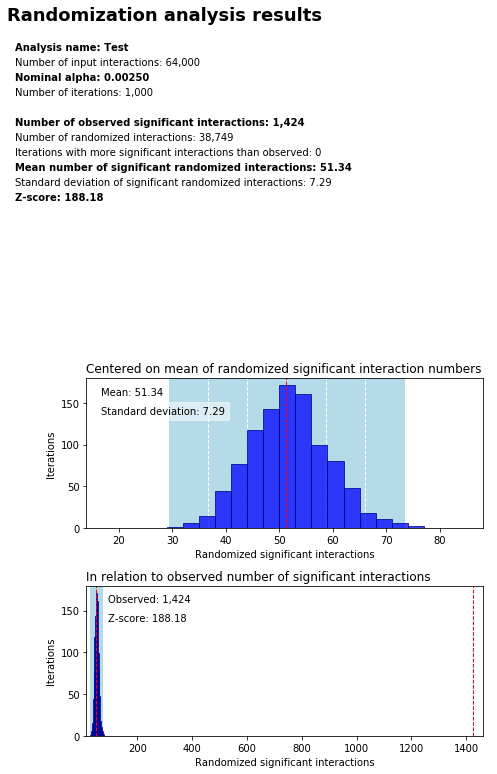

In [7]:
# Create plot with a histogram for the randomized significant interaction numbers from all iterations
fig = randomization_analysis_demo.get_randomization_info_plot(
    pdf_file_name = 'randomization_analysis.pdf',
    analysis_name = 'Test')

The header of the plot contains all the information about the analysis that is also contained in the formatted string decribed above. Below that, there are two histograms that show the distribution of the numbers of randomized significant interactions from all iterations. The upper histogram is centered on the mean at which a red dashed line is drawn. In addition, the range of three standard deviations to the left and right of the mean is highlighted in light blue. The lower histogram shows the same data in relation to the originally observed number of significant interactions at which a second red dashed line is drawn.

## Results of the randomization depending on the number of iterations

XXX

In [13]:
results_iter_num = {}
for iter_num in range(100,1000 + 100,100):   
    print(iter_num)
    results_iter_num[iter_num] = randomization_analysis_demo.perform_randomization_analysis(
    nominal_alpha = 0.0025,
    iter_num = iter_num,
    thread_num = 0,
    verbose = True)

100
[INFO] Performing randomization analysis with 100 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 100 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.
200
[INFO] Performing randomization analysis with 200 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 200 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.
300
[INFO] Performing randomization analysis with 300 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 300 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
	[INFO] Ca

In [23]:
iter_nums = list(range(100,1000 + 100,100))
z_scores = []
sig_num_r_means = []
sig_num_r_sds = []
for iter_num in iter_nums:   
    z_scores.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['Z_SCORE'][0])
    sig_num_r_means.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0])
    sig_num_r_sds.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['SIG_NUM_R_STD'][0])
print(z_scores)
print(sig_num_r_means)
print(sig_num_r_sds)

[198.900730129281, 188.9376594160668, 191.96819116109864, 188.49431263092387, 194.1602211812989, 195.07608138072845, 191.83151505891522, 190.23045560848178, 189.31092534375406, 188.18328295494584]
[51.01, 51.22, 51.18, 51.6275, 51.636, 51.38333333333333, 51.15, 51.18625, 51.19777777777778, 51.34]
[6.902890698830454, 7.265782820866585, 7.151288928111725, 7.280710387730034, 7.0682037322080635, 7.0363145340598745, 7.156540465097045, 7.216582358533712, 7.251574201169131, 7.294271725127876]


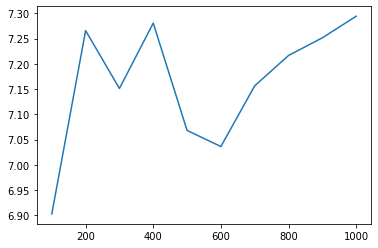

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot(iter_nums,z_scores)
#plt.plot(iter_nums,sig_num_r_means)
plt.plot(iter_nums,sig_num_r_sds)


## Results of the randomization depending on the number of input interactions

XXX

## Results of the randomization depending on the nominal alpha

XXX

## Script to run the randomization analysis

XXX